## TODO: Commentare CODICE!, BackPropagation, Funzioni per la validazione, creata la rete neurale da utilizzare prima i datasets MONK e sul dataset per la CUP .

Import delle librerie ("as" serve a specificare come nel codice le librerie vengono richiamate.):
- **matplotlib** per creare in output grafici
- **pandas** per gestire i csv o gli excel
- **numpy** per operazioni su matrici e vettori
- **time** per valutazione sui tempi di esecuzione

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

Import libreria **sklearn** per il machine learning utilizzata per i primi Test, forse non serviranno in futuro
- load_breast_cancer: datasets per primi test
- traint_test_split: divide il dataset in maniera randomica creando il training set e il test set in base a i parametri dati
- mean_squared_error per verificare se la nostra versione funziona 

In [3]:
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


Funzione **init_wb** che inizializza i pesi W e i Bias a zero.
- l_dim array che continene la dimensione della rete (include anche l'input layer e l'output layer). *Esempio rete con 6 input due hidden layer da 3 e 5 unità e un singolo output prende in input l'array [6,3,5,1]*
- parametro seed per la funzione random così da avere numeri casuali uguali per test sugli stessi dati.
- eps un valore tra 0 e 1 per regolarizzazione ulteriore dei pesi W facendogli assumere valori bassi di default è 1

In [4]:
R_SEEDS=30
EPS=0.1
B=0
def init_wb(l_dim, seed=R_SEEDS,eps=EPS,b=B,uniform=False,**kwargs):
    np.random.seed(seed)
    wb = {}
    
    #L dimensione della rete
    L = len(l_dim)
    
    for l in range(1, L):
        #Inizializzo i pesi maniera randomica e in un range regolato da eps
        if not uniform:
            wb['W'+str(l)] = np.random.randn(l_dim[l],l_dim[l-1]) * eps
        else:
            wb['W'+str(l)]=np.random.uniform(-0.1, 0.1,(l_dim[l],l_dim[l-1]))*eps
        #Inizializzo i bias a zero  
        wb['b'+str(l)] = np.full((l_dim[l], 1),b)
        
    return wb

Test di **init_wb** che stampa la dimensione e l'array dei pesi dei layer.
La Matrice W risultante sarà  quindi per n numero unità layer e m numero input<br>
[w1,1 w1,2 ... w1,m]<br>
[w2,1 w2,2 ... w2,m]<br>
[          ...     ]<br>
[wn,1 wi,2 ... wi,m]<br>

**w**ij il peso relativo all'unità *i* e l'input *j*. I bias sono di default zero per ogni layer

In [5]:
l_dim=[6,3,2,1]
L=len(l_dim)
def pippo(**kwargs):
    wb=init_wb(l_dim,**kwargs)
    for l in range(1,L):
        print("Shape W"+str(l),wb["W"+str(l)].shape, "Shape b"+str(l),wb["b"+str(l)].shape,wb["W"+str(l)] )
        print(wb["b"+str(l)] )
pippo(seed=30,eps=0.1,pippo=123)

Shape W1 (3, 6) Shape b1 (3, 1) [[-0.12640527  0.15279054 -0.09707109  0.04705596 -0.01006967  0.03037932]
 [-0.17259624  0.15850954  0.01342966 -0.11068555  0.15782255  0.01074979]
 [-0.07640478 -0.07751885  0.13838472  0.07603851 -0.02856455  0.05383675]]
[[0]
 [0]
 [0]]
Shape W2 (2, 3) Shape b2 (2, 1) [[-0.20838966  0.09377817 -0.0005778 ]
 [-0.0467479  -0.04230153  0.10644821]]
[[0]
 [0]]
Shape W3 (1, 2) Shape b3 (1, 1) [[-0.29033676  0.16168904]]
[[0]]


###### !Ditemi se vi torna come l'ho spiegata, non sono convinto! 
La funzione **linear_af** applica  funzione lineare utilizzando la matrice **W** dei pesi e il dataset degli input **X**.<br>
*p* numero dei pattern di X, *n* dimensione degli input, *i* numero unità.<br>
- x*pj* = input j del pattern p
- w*ij* = peso j unita i
- h(xip) = output dell'unità i del pattern p
$$ h(x_{ip}) = \sum_{1}^n w_{ij} * x^T_{jp} $$

In [6]:
def linear_af(w,X,b):
    h = np.dot(w,X.T)+b
    
    return h

Test della funzione **linear_af** (linear activation function)
Nella stampa  due unità quindi con riferimento all'esempio precedente **i** da 1 a 2, 6 input **j** da 1 a 6 e due pattern **p** da uno a 2. 
Risultato una matrice h con nelle righe l'output di ogni unità e sulle colonne l'output relativo al pattern


In [7]:
np.random.seed(30)
#Pesi per due unità matrice 2x6 (riga pesi unità) (colonna pesi per input)
w= np.random.randn(2,6)
#Input random con valori zero e uno 2x6 (riga  pattern da sei input) quindi due pattern da sei input
X = np.random.randint(2, size=(2,6))
b = np.ones((1,1))

print("W",w,"X",X,"b",b,sep="\n")
# L'output della funzione h sarà una 2x2 ogni unità  (riga) avrà un output per ogni pattern (colonna)
h= linear_af(w,X,b)
print("H",h,sep="\n")


W
[[-1.26405266  1.52790535 -0.97071094  0.47055962 -0.10069672  0.30379318]
 [-1.72596243  1.58509537  0.13429659 -1.10685547  1.57822555  0.10749794]]
X
[[0 0 1 0 1 0]
 [0 1 1 1 0 1]]
b
[[1.]]
H
[[-0.07140765  2.33154721]
 [ 2.71252214  1.72003444]]


**perceptron_af** Perceptron activation function. Ritorna il segno della funzione lineare quindi -1 o +1, se parametro zero è True ritorna 0 al posto di -1.
- net risultato della rete (funzione lineare)
- zero booleano di default è falso

In [8]:
def perceptron_af(net,zero=False):
    x=np.array(np.sign(net))
    if zero:
        x=np.where(x<0,0,x)
    return x

Test della funzione **perceptron_af** su l'h del precedente test e su un input continuo


[[0. 1.]
 [1. 1.]]
[[-1.  1.]
 [ 1.  1.]]


Text(0, 0.5, 'Sign(X)')

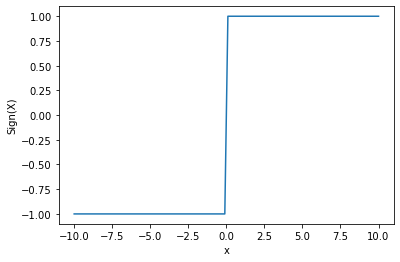

In [9]:
print(perceptron_af(h,zero=True))
print(perceptron_af(h))

x = np.linspace(-10, 10, 100)
z =np.sign(x)
plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("Sign(X)")

**sigmoid_af** Sigmoid activation function. Ritorna il valore dalla sigmoide applicato alla funzione lineare.
- net risultato della rete (funzione lineare)
$$ \sigma_{(net)} = \frac{1}{e^{-net}} $$
**sigmoid_derivative** derivata della sigmoide:
    $$ \sigma^{'}=\sigma_{(net)} * (1 - \sigma_{(net)}) $$

- net risultato della rete (funzione lineare) 



In [10]:
def sigmoid_af(net):
    #sf= 1/(1 + np.exp(-net))
    #return sf
    return np.divide(1, np.add(1, np.exp(-net)))
    

def sigmoid_derivative(net):
    return np.multiply(sigmoid_af(net),np.subtract([1.] * len(net.T), sigmoid_af(net)))

Test sigmoid activation function sul risultato del precedente h e stampa del grafico su valori continui


[[0.48215567 0.91145628]
 [0.93776152 0.84813327]]


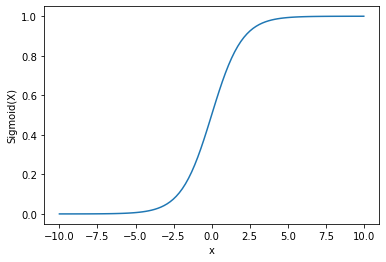

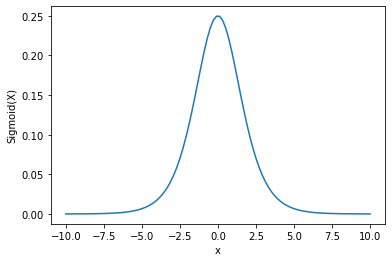

In [11]:
s=sigmoid_af(h)
print(s)
x = np.linspace(-10, 10, 100)
z = sigmoid_af(x)
plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")
  
plt.show()
z = sigmoid_derivative(x)
plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")
  
plt.show()

Funzione **mse** calcola il Mean squared error parametri:
- matrice dei target **Y** 
- matrice **Y_hat** delle predizioni
- reg valore regolarizzazione di default 0
- a_loss array nel quale si vuole appendere la loss calcolata
 $$MSE  = \frac{1}{2n} \sum_{i=1}^n (Y_i - \hat{Y}_i)^2 $$

Nota: Nel codice è comentata una linea nel caso si voglia moltiplicare la media per 1/2l cosi da eliminare il due, perché nel calcolo della dericata della cost functionsi può togliere la moltiplicazione per meno due. L'ho trovato scritto in entrambi i modi non sono convinto quale sia il migliore.

In [12]:
def mse(Y,Y_hat,verbose=False):
    l= Y.shape[0]
    dp = np.squeeze(Y) - np.squeeze(Y_hat)
    loss=np.sum(np.square(dp))
    #loss=loss*(1/l)
    #PRINT PER CONTROLLARE LE DIMENSIONI
    if verbose:
        print("Y:",Y.shape, "Y_hat",Y_hat.shape,"Y - Y_hat:",np.subtract(Y,Y_hat).shape,sep="\n")
        print("Y:",Y,"Y_hat:",Y_hat)
        print("Y-Y_hat",np.subtract(Y,Y_hat))
    
    #cancellando il due
    loss=  loss * (1/(2*l))
    return loss


def mse_derivative(Y,Y_hat):
    dp = (np.squeeze(Y) - np.squeeze(Y_hat)) * -1
    return dp



Funzione **gradient_mse** calcola il  gradiente del Mean squared error prametri:
- matrice dei  target **Y** 
- matrice degli **Y_hat** delle predizioni
- matrice degli input **X**
    $$Gradient\ MSE \quad = \frac{\delta E_{(W)}}{\delta w_j} = -  \sum_{p=1}^n (y_p - \hat{y}_p) * x_{p,j} $$ $$ \delta_p = ( \hat{y}_p - y_p ) $$
  Utilizzando le operazioni con le matrici:
  $$ \Delta W \quad = \ - \frac{\delta E_{(W)}}{\delta w_j} \ =  (Y - \hat{Y}) * X $$


In [13]:
def gradient_mse(Y,Y_hat,x,verbose=False):
    dp = mse_derivative(Y,Y_hat)
    #p = il numero dei pattern che corrisponde al numero di righe di Y.
    p = Y.shape[0]
    #cancellando il due nell'mse non devo molptiplicare per meno due
    gradient = np.dot(dp,x)
    #divido i gradienti trovati per p che è il numero dei pattern
    gradient = gradient/p
    #PRINT PER CONTROLLARE LE DIMENSIONI    
    if verbose==True:
        print("Y shape", Y.shape,"Y_hat shape", Y_hat.shape,"Subtract Shape",np.subtract(Y,Y_hat).shape)
        print("Y",Y,"Y_H",Y_hat)
        print("Y-Y_H",np.subtract(Y,Y_hat))
        print("GMSE Sub:",dp.shape, x.shape)
    return gradient

Funzione **mse** applicando la sigmoide alla rete passata come argomento. Parametri:
- matrice dei target **Y** 
- matrice net della funzione lineare Wt*x + b
- a_loss array nel quale si vuole appendere la loss calcolata

In [14]:
def mse_logistic(Y,net,reg=0,a_loss=None):
    sig=sigmoid_af(net)
    
    return mse(Y,sig, 0, reg, a_loss)

Calcolo del gradiente applicato alla sigmoide
$$ \frac{\delta E(w)}{\delta w_j} \ = \ -\sum_{p=1}^{l}(d_p - o(x_p))f_{\sigma}^{'} x_{p,j} $$ $$ new \ \delta_{p} = (d_p - o(x_p))f_{\sigma}^{'}$$ $$ \Delta W  \ = \ - \frac{\delta E(w)}{\delta w_j}= \ new\  \delta_p \  x_{p,j} $$

In [15]:
def gradient_mse_logistic(Y,net,out):
    dp=delta_mse_logistic(Y,net)
    p = Y.shape[0]
    gradient = (np.dot(dp,out))
    gradient = gradient/p
    
    return gradient

def delta_mse_logistic(Y,net):
    sig=sigmoid_af(net)
    dsig=sigmoid_derivative(net)
    print(sig.shape)
    dmse=mse_derivative(Y,sig)
    newdp=dmse*dsig
    return newdp

Questa funzione applica l'equazione normale per trovare la soluzione direttamente. Non so se serve nel progetto, l'ho implementata per prova.
We can get the normal equation (point with gradient of E w.r.t w =0):
$$ (X^T X)w = X^Ty $$
- If X^TX is not singular the unique solution is given by: $$ w= (X^T X)^{-1}X^T y = X^{+} y $$
    - "+" = Moore-Penrose pseudoinverse (also if X is not invertible)
- Else the solution are infinite (satisfying the normal equation):
we can choose the min norm (w) solution 

Normal Equation:
- don't need to choose α 
- don't need to iterate - computed in one step 
- slow if n is large (n⩾10^4)
- need to compute (X^T X)^−1 - very slow 
- if (X^T X) is not-invertible - we have problems

Gradient Descent: 
- need to choose learning rate α 
- need to do many iterations 
- works well with large n


In [16]:
def normal_equation(X,Y,pseudo=False):
    if pseudo:
        pinv=np.linalg.pinv(X)
        direct=pinv.dot(Y)
    else:
        direct=np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
    
    return direct
    

Test del calcolo del gradiente e della funzione di costo con array del dataset Load Breast Cancer.
- Calcolo l'mse con la nostra funzione e confronto con la libreria SKLEARN

- Provo se riesce il calcolo del gradiente della funzione di costo applicato alla funzione lineare (DA VERIFICARE SE CORRETTO)
- Provo se riesce il calcolo del gradiente della funzione di costo applicato alla funzione logistica (DA VERIFICARE SE CORRETTO)

- Calcolo il costo utilizzando il metodo diretto dell'equazione normale. 

In [17]:
X, y = load_breast_cancer(return_X_y= True)
X_dev, X_test, y_dev, y_test = train_test_split(X,y,test_size=100, stratify=y, shuffle=True, random_state=42)
l_dim=[X_dev.shape[1],1,1]
wb=init_wb(l_dim,eps=0.001)
w=wb["W"+str(1)]
b=wb["b"+str(1)]
h = linear_af(w,X_dev,b)
print("Cost MSE= ", mse(y_dev,h))
print("Cost MSE SKLEARN=" ,mean_squared_error(y_dev,h.T)/2)
print("Gradient", gradient_mse(y_dev,h,X_dev))
print("Gradient Sigmoid", gradient_mse_logistic(y_dev,h,X_dev))

direct=normal_equation(X_dev,y_dev,True)
print("Direct",direct )
dh=linear_af(direct,X_dev,b)
cost=mse(y_dev,dh)
print("Cost Normal Equation", cost)

Cost MSE=  0.6824960914095499
Cost MSE SKLEARN= 0.6824960914095499
Gradient [9.63646269e+00 1.02869604e+01 6.42121898e+01 6.26243240e+02
 4.65854073e-02 7.99619145e-02 1.02389535e-01 5.68788318e-02
 8.74654988e-02 2.64094358e-02 3.80734959e-01 4.85079037e-01
 2.70110433e+00 5.14126646e+01 2.60631543e-03 1.62354866e-02
 2.20637400e-02 7.81907697e-03 8.64701588e-03 1.69223078e-03
 1.20403297e+01 1.39620806e+01 8.11006331e+01 9.48587203e+02
 6.56778688e-02 2.05291490e-01 2.67762747e-01 1.08739310e-01
 1.50399056e-01 4.06985541e-02]
(1, 469)
Gradient Sigmoid [[ 1.09230202e-01  2.03200518e-02  8.19213721e-01  1.44011836e+01
  -2.26500097e-04  2.06632221e-03  3.98991194e-03  2.12169264e-03
  -3.96110891e-04 -4.40198835e-04  8.28403453e-03 -1.13338983e-02
   6.01110119e-02  1.40256231e+00 -8.43828900e-05  2.82619777e-04
   4.39386461e-04  1.41125358e-04 -1.56257127e-04 -1.49717348e-05
   1.83750297e-01  7.08205738e-02  1.34479512e+00  2.47363924e+01
  -8.50132569e-05  6.96224211e-03  1.067583

La funzione **classification_error** prende come parametri y il valori reali e y_hat la predizione di classificazione della rete. Ritorna il numero di predizioni errate

In [18]:
def classification_error(y, y_hat,verbose=False):
    num_err=0
    index = 0
    if verbose==True:
        print("Y shape",y.shape,"Y_H shape",y_hat.shape)
    y_hat=np.squeeze(y_hat)
    for o in  y_hat:
        if o != y[index]:
            num_err+=1
        index+=1
    return num_err

Funzione **gradient_descent** calcola la nuova matrice W utilizzando la formula del gradient descent.
Parametri:
    - W matrice dei pesi
    - eta learning rate
    - gradiente dell'Errore rispeto alla matrice W
Ritorna la nuova matrice W

In [19]:
def gradient_descent(w,eta,gradient):
    dw= - gradient
    newW= w + (eta * dw)
    
    return newW

Test dell'algoritmo del gradient descent e confronto dei costi prima e dopo l'aggiornamento di W sia con gradiente che senza

In [20]:
print("Error Gradient: ", gradient_mse(y_dev,h,X_dev))
cost=mse(y_dev,h)
print("Cost: ",cost)
eta=0.0000001
newW= gradient_descent(w,eta,gradient_mse(y_dev,h,X_dev))
gh=linear_af(newW,X_dev,b)
cost=mse(y_dev,gh)
print("Cost with new W: ",cost)
tihk=0.1
reg= tihk * np.square(np.linalg.norm(w))
print("Penalty term: ",reg)
cost=mse(y_dev,h) 
print("Cost with penalty term: ",cost)
gradreg = 2*tihk*w
newW = gradient_descent(w,eta,gradient_mse(y_dev,h,X_dev) - gradreg)
gh=linear_af(newW,X_dev,b)
cost=mse(y_dev,gh)
print("Cost new W with penalty term: ",cost)


Error Gradient:  [9.63646269e+00 1.02869604e+01 6.42121898e+01 6.26243240e+02
 4.65854073e-02 7.99619145e-02 1.02389535e-01 5.68788318e-02
 8.74654988e-02 2.64094358e-02 3.80734959e-01 4.85079037e-01
 2.70110433e+00 5.14126646e+01 2.60631543e-03 1.62354866e-02
 2.20637400e-02 7.81907697e-03 8.64701588e-03 1.69223078e-03
 1.20403297e+01 1.39620806e+01 8.11006331e+01 9.48587203e+02
 6.56778688e-02 2.05291490e-01 2.67762747e-01 1.08739310e-01
 1.50399056e-01 4.06985541e-02]
Cost:  0.6824960914095499
Cost with new W:  0.5624047067220123
Penalty term:  4.261717943104881e-06
Cost with penalty term:  0.6824960914095499
Cost new W with penalty term:  0.5624047263496315


Importo Nuovamente i datasets di test e verifico le dimensioni

In [21]:
X, y = load_breast_cancer(return_X_y= True)
#X_dev, X_test, y_dev, y_test = train_test_split(X,y,test_size=100, stratify=y, shuffle=True, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X,y,test_size=100, stratify=y, shuffle=True, random_state=42)

X_dev.shape, X_test.shape

((469, 30), (100, 30))

Test errore di classificazione sul dataset breast cancer. Per prima cosa creo una rete con un singola unità. Applico l'equazione normale per trovare i valori di W e applico la la funzione lineare. Utilizzo il perceptron come funzione di attivazione e verifico gli elementi classificati errati sia sul training test che sul test set.

In [22]:
l_dim=[X_dev.shape[1],1,1]
wb=init_wb(l_dim,eps=0)
w=wb["W"+str(1)]
b=wb["b"+str(1)]
l = y_dev.shape[0]
#applico l'equazione normale per trovare la soluzione 
normalw = normal_equation(X_dev,y_dev)
#applico la funzione lineare alla soluzione trovata
h=linear_af(normalw,X_dev,b)
#utilizzo la funzione di attivazione del perceptron per recuperare i segni della mia funzione lineare
out=perceptron_af(h,zero=True)
#verifico il numero di errori di classificazione
err=classification_error(y_dev,out)
print("Train set # Errori ",err, "su:",y_dev.shape[0],"elementi =",(l-err)/y_dev.shape[0]*100,"%")

cost_history=[]
cost = mse(y_dev,out)
cost_history.append(cost)
skcost=mean_squared_error([y_dev],out)/2

#Applico al Test set
h=linear_af(normalw,X_test,b)

out=perceptron_af(h,zero=True)

cost2= mse(y_test,out)
cost_history.append(cost2)

skcost2=mean_squared_error(y_test,out.T)/2
#print("W",normalw,"Out",h)
tl = y_test.shape[0]

terr=classification_error(y_test,out)
print("Test set # Errori ",terr, "su:",y_test.shape[0],"elementi =",(tl-terr)/y_test.shape[0]*100,"%")
print("MSE Train set NormalEquation: ",cost,"MSE Test set NormalEquation: ",cost2 )
print("SKlearn MSE Train set NormalEquation: ",skcost,"SKlearn MSE Test set NormalEquation: ",skcost2, )


Train set # Errori  119 su: 469 elementi = 74.6268656716418 %
Test set # Errori  28 su: 100 elementi = 72.0 %
MSE Train set NormalEquation:  0.12686567164179105 MSE Test set NormalEquation:  0.14
SKlearn MSE Train set NormalEquation:  0.12686567164179105 SKlearn MSE Test set NormalEquation:  0.14


Funzione che calcola la regolarizzazione di Tikhonov e il suo gradiente

In [27]:
def tikhonov(lambdat, w):
    return lambdat * np.square(np.linalg.norm(w))

def tikhonov2(tlambda,w):
    return tlambda * np.sum(np.square(w))


def gradient_Tikhonov(lambdat,w):
    return 2*lambdat*w
    

Test errore di classificazione sul dataset breast cancer. Per prima cosa creo una rete con un singola unità. Parametri:
- eta learning rate
- lambda (Tikhnov) valore di regolarizzazione
    * Note that for the objective function we use here the name Loss (used for the model training cost function) to distinguish from the Error E (useful to evaluate the model error and used for the data term inside this Loss). 
$$ Loss(w) = \sum_{p=1}^{l} (y_p - x_p^T)^2 + \lambda \lVert {w} \rVert^2 $$
     * **Nota**  The balancing (trade-off) between the two terms: 
     * Small lambda value: minimizing the loss the focus is on obtaining a small error data term (first term, minimize just the training error) with a too complex model (high norm of the weights), the risk is of overfitting,
     * High lambda: minimizing the loss the focus is on the second term, hence the data error (first term) could grow too much i.e. moving to underfitting
- epoch numero di epoche di addestramento
Per ogni epoca calcolo il termine di penalità e il gradiente aggiugendo anche il gradiente del termine di penalità 
$$ w_{new}= w + \eta * \Delta w - 2 \lambda w $$

Dopo l'addestramento faccio il plot dei costi per ogni epoca e applico il modello addestrato al dataset di Test

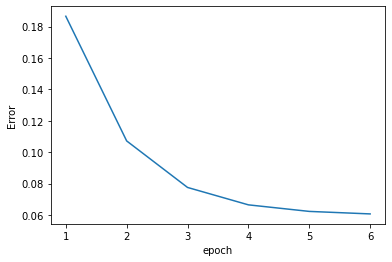

Loss Train:  0.060675287961051594
Train set # Errori  159 su: 469 elementi = 66.09808102345416 %
[[ 0.8008939   0.7393824   0.36802728  0.26729539  0.65819676  0.67565145
   0.62112908 -0.12950728  0.66040338  0.79879444  0.65859865  0.70152454
   0.53811021  0.09358192  0.66260947  0.55821615  0.68447583  0.80178338
   0.69368528  0.17690719  0.6167862   0.77583803  0.85301439  0.7805907
   0.69203329  0.68336148  0.70033249  0.66573819  0.21402324  0.50961555
  -0.4830458   0.51717795  0.41647242  0.62120126  0.74138898  0.70585478
   0.15679881  0.79358829  0.80293189  0.74972463  0.26405954  0.69202237
   0.74340589  0.61437848  0.65017167  0.60121328  0.76982471  0.33958711
  -0.88193562  0.76371128  0.73248818  0.85188946  0.62463472  0.35933793
   0.16960744  0.47622808  0.05208142  0.65744895  0.5370785   0.83432713
   0.22636246  0.69875676  0.73844836  0.85872942  0.72511875  0.78899391
   0.26102208  0.27802887  0.50427358  0.15999377  0.74516859  0.70012095
   0.85372503  0

In [31]:
l_dim=[X_dev.shape[1],1,1]
wb=init_wb(l_dim,eps=0,b=1)
w=wb["W"+str(1)]
b=wb["b"+str(1)]
cost_history=[]
eta=1/1000000
lambdat=0.00001
epoch=7

for i in range (1,epoch):
    #print("w",i,":",w.shape)
    #print("x",i,":",X_dev.shape)
    #Applico la funzione lineare
    h=linear_af(w,X_dev,b)
    #print("h",i,":",h.shape)
    cost= mse(y_dev, h)
    cost_history.append(cost)
    #Trovo il gradiente della funzione di Errore
    gradient = gradient_mse(y_dev, h, X_dev)
    #print("gradient",i,":",gradient.shape)
    #Applico il gradient descent per trovare i nuovi valori di w
    w = gradient_descent(w,eta,gradient)

plt.plot(range(1,epoch),cost_history)
plt.xlabel("epoch")
plt.ylabel("Error")
plt.show()

#Train SET eseguo il modello trovato sul train e test set
l = y_dev.shape[0]
h=linear_af(w,X_dev,b)
out=perceptron_af(h,zero=True)
err=classification_error(y_dev,out)
print("Loss Train: ",cost)
print("Train set # Errori ", err , "su:",y_dev.shape[0],"elementi =",(l-err)/y_dev.shape[0]*100,"%")

#TEST SET
tl = y_test.shape[0]
h=linear_af(w,X_test,b)
print(h)
out=perceptron_af(h)

cost2=mse(y_test,out)
print("Loss Test: ",cost2)
terr=classification_error(y_test,out)
print("TEST set # Errori ", terr , "su:",y_test.shape[0],"elementi =",(tl-terr)/y_test.shape[0]*100,"%")

In [50]:
tik=0
wb=init_wb([1,2,3],b=0.1)

for l in range(1,len(l_dim)):
    print("Tw",l,":",tikhonov(lambdat,wb['W'+str(l)]))
   
    print("Tb",l,":",tikhonov(lambdat,wb['b'+str(l)]))
    tik+=tikhonov(lambdat,wb['W'+str(l)])+tikhonov(lambdat,wb['b'+str(l)])
print(totalw)

print("tik:",tik)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 2

Funzione che applica l'algoritmo del perceptron_learning:
1. Initialize the weights (either to zero or to a small random value)
2. pick a learning rate eta ( this is a number between 0 and 1) 
3. until stopping condition is satisfied (e.g. weights don't change): <br> For each training pattern (x, y) (y = +1 or –1): 
 - Compute output activation out = sign(wT x) [+1,-1]
 - If out = y, don't change weights I.e. “minimize (only) misclassifications”
 - If out <> y, update the weights:
 $$ w_{new} = w + \eta  * y * x $$
    * add   + eta x if wx ≤ 0 and y=+1 or  - eta x if wx > 0 and y=-1 <br>
    Or $$ w_{new}= w + \eta (y-out) x$$
    $$ y-out = \delta \\ w_{new}= w + \ \eta \ \delta \ x$$
 
 Parametri pesi W e bias B, learning rate eta, valori target y, input x, epoche di addestramento, verbose per la stampa di informazioni. Ritorna una tupla con i pesi aggiornati newW, il numero di valori errati, il numero i iterazioni effettuate

In [24]:
def perceptron_learning(w,b,eta,y,x,epochs,verbose=False):
    #print("Shape d: ",d.shape," out: ",out.shape,"X: ",x.shape,"d-out: ",(np.subtract(d,out)))
    newW=w
    iter_miss=[]
    i=0
    miss=-1
    ok=0
    # Inizio l'addestramento termino se non ho nessuna misclassificazione o se raggiungo il numero limite di epoche
    while miss!=0 and i!=epochs:
        miss=0
        ok=0
        for p, xp in enumerate(x):
            #ciclo i singoli pattern p
            xp=np.reshape(xp,(1,xp.shape[0]))
            #applico il perceptron al pattern 
            out = perceptron_step(newW,xp,b)
            #calcolo y - out
            yout=np.squeeze(y[p]) - np.squeeze(out)
            # Se è diverso da zero aggiorno i pesi
            if yout!=0:
                #delta rule
                newW +=  1/2* eta * (yout * xp)
                miss+=1
                if verbose:
                    print("Errore numero",miss,"out:",out,"y:",y[p],"y-out",yout)
        i+=1;
        iter_miss.append(miss)
        if verbose and i % 500 == 0:
            print(i)
    return newW,iter_miss,i

def perceptron_step(w,x,b):
    h=linear_af(w,x,b)
    return perceptron_af(h,zero=True)
    

Test del Perceptron Algorithm: Inizializzo i pesi per una unità setto un valore di eta e un numero di epoche e avvio l'algoritmo sul dataset di train. Alla fine dell'esecuzione controllo il numero di errori nella classificazione sia nel dataset di train che di test. TO DO: Da testare con il monk?

Train set # Errori  48 su: 469 elementi = 89.76545842217483 %


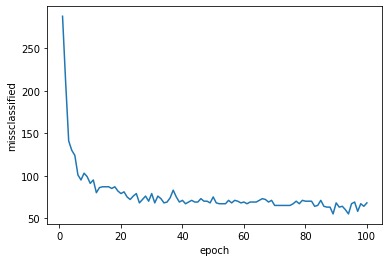

TEST set # Errori  12 su: 100 elementi = 88.0 %


In [25]:
l_dim=[X_dev.shape[1],1,1]
wb=init_wb(l_dim,eps=0.00001)
w=wb["W"+str(1)]
b=wb["b"+str(1)]

eta=0.000000001
epochs=100


newW,miss,i= perceptron_learning(w,b,eta,y_dev,X_dev,epochs)

#Train set
out=perceptron_step(newW,X_dev,b)
nerr=classification_error(y_dev,out)

l = y_dev.shape[0]
print("Train set # Errori ", nerr , "su:",y_dev.shape[0],"elementi =",(l-nerr)/y_dev.shape[0]*100,"%")
plt.plot(range(1,epochs+1),miss)
plt.xlabel("epoch")
plt.ylabel("missclassified")
plt.show()

#Test set
out=perceptron_step(newW,X_test,b)
tl = y_test.shape[0]
terr=classification_error(y_test,out)
print("TEST set # Errori ", terr , "su:",y_test.shape[0],"elementi =",(tl-terr)/y_test.shape[0]*100,"%")


La funzione **forward_propagation** che effettua la propagazione in una rete neurale. I parametri:
- X matrice degli input
- w matrice dei pesi
- b matrice dei bias
- f la funzione di attivazione da applicare

In [26]:
def forward_propagation(X,w,b,f_activation):
    h = linear_af(w,X,b)
    out = f_activation(h).T
    return h,out


Test della Forward propagation, inizializzo la rete con 2 hidden layer uno da 15 e 7 unità

In [27]:
l_dim=[30,15,7,1]
L=len(l_dim)
wb=init_wb(l_dim,30,0.01)
out=X_dev
hout = {}
hout["o0"]=X_dev
for l in range(1,L):
    net,out= forward_propagation(out,wb["W"+str(l)],wb["b"+str(l)],sigmoid_af)
    
    hout["o"+str(l)]=out
    hout["h"+str(l)]=net
#gradient=back_propagation(y_dev,caches,wb,sigmoid_derivative)
    
cost = mse(y_dev, out)
print("MSE",cost)
print("SKLearn", mean_squared_error(y_dev,out)/2)

MSE 0.12492233267981837
SKLearn 0.12492233267981837


In [28]:
#y vettore dei target
#out matrice degli output dell'ultimo layer rete
#d_activation con le derivate della funzione di attivazione
#Ritorna delta_k matrice con i delta dell layer di output con riga corrispondente pattern e colonna Kesima unita output
def compute_delta_k(y,out,net,d_loss,d_activation):
    dp=d_loss(y,out)
    f_prime=d_activation(net)
    delta_k=dp*f_prime
    return delta_k.T
#delta_in matrice delta del layer successivo righe unità colonne pattern
#w_layer matrice dei pesi del layer Win_j righe unità colonne input
#d_activation matrice contenente i valori della derivata della funzione di attivazione righe unità colonne pattern
#return delta_J righe patter colonne jiesimo delta
def compute_delta_j(delta_in,w_layer,net,d_activation):
    dt=delta_in@w_layer
    dj=dt * d_activation(net).T
    return dj

def update_wb(wb,eta,delta,hout):
    newwb={}
    for l in range(len(l_dim)-1,0,-1):
        newwb['W'+str(l)]= wb['W'+str(l)] + (eta * -(delta[l-1].T@hout['o'+str(l-1)]))
        newwb['b'+str(l)]= wb['b'+str(l)] + eta * np.sum(delta[l-1])
    return newwb
        
def back_propagation(y,out,d_loss,d_activation,wb,L,eta):
    delta_t=[]
    for l in range(L-1,0,-1):
        dt=0
        if l==L-1:
            dt = compute_delta_k(y,out,hout["h"+str(l)],d_loss,d_activation)
        else:
            dt = compute_delta_j(delta_t[-1],wb['W'+str(l+1)],hout["h"+str(l)],d_activation)
        delta_t.append(dt)
    return delta_t[::-1]

Backpropagation Algoritmo:
        $$Inizializzazione \ dei \ pesi\ \pmb{w} \ nella \ rete \ e \ di \ \pmb{\eta}; \\
    Calcolare \ l'out \ e \ E_{tot} ;\\
    while \ E_{tot} > \epsilon \ (valore \ desiderato) \ do: \\
     \ \forall w \in \pmb{w}: \Delta w= - \ \frac{\delta E_{tot}}{\delta w}; \ (Step \ 1) \\
     \ w^{new} \gets w \ + \  \eta \Delta w \ + \ ... \ ; \ (Step \ 2) \\
     \ Calcolare \ out \ e \ E_{tot} \\
    end
    $$

In [29]:
l_dim=[X_dev.shape[1],3,1]
wb=init_wb(l_dim,eps=1)
L=len(l_dim)
hout = {}
X_norm = preprocessing.scale(X_dev)
hout["o0"]=X_norm
a_loss=[]
epochs=800
eta=0.001
h_loss=[]
for i in range(0,epochs):
    out=hout["o0"]
    for l in range(1,L):
        net,out= forward_propagation(out,wb["W"+str(l)],wb["b"+str(l)],sigmoid_af)
        hout["o"+str(l)]=out
        hout["h"+str(l)]=net
    h_loss.append(mse(y_dev,out))
    delta=back_propagation(y_dev,out,mse_derivative,sigmoid_derivative,wb,L,eta)
    wb=update_wb(wb,eta,delta,hout)
out=hout["o0"]
for l in range(1,L):
    net,out= forward_propagation(out,wb["W"+str(l)],wb["b"+str(l)],sigmoid_af)
    hout["o"+str(l)]=out
    hout["h"+str(l)]=net
h_loss.append(mse(y_dev,out))
plt.plot(range(0,epochs+1),h_loss)
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.show()

print("MSE:",mse(y_dev,hout["o"+str(l)]))
print("SKLearnMSE",mean_squared_error(y_dev,hout["o"+str(l)])/2)
#Train set
signout=np.sign(hout["o"+str(l)])
for i,s in enumerate (hout["o"+str(l)]):
    if s[0]<=0.5:
        signout[i][0]=0
    else:
        signout[i][0]=1

nerr=classification_error(y_dev,signout,True)
l = y_dev.shape[0]
print("Train set # Errori ", nerr , "su:",y_dev.shape[0],"elementi =",(l-nerr)/y_dev.shape[0]*100,"%")
X_testnorm = preprocessing.scale(X_test)
hout["o0"]=X_testnorm
out=hout["o0"]
for l in range(1,L):
    net,out= forward_propagation(out,wb["W"+str(l)],wb["b"+str(l)],sigmoid_af)
    hout["o"+str(l)]=out
    hout["h"+str(l)]=net
print("MSE:",mse(y_test,hout["o"+str(l)]))
print("SKLearnMSE",mean_squared_error(y_test,hout["o"+str(l)])/2)

#Test set
signout=np.sign(hout["o"+str(l)])
for i,s in enumerate (hout["o"+str(l)]):
    if s[0]<=0.5:
        signout[i][0]=0
    else:
        signout[i][0]=1
tl = y_test.shape[0]
terr=classification_error(y_test,signout)
print("TEST set # Errori ", terr , "su:",y_test.shape[0],"elementi =",(tl-terr)/y_test.shape[0]*100,"%")

NameError: name 'newwb' is not defined